<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/TIGER_ETF%EB%AA%A8%EB%A9%98%ED%85%80(10%EB%85%84_%EC%84%B1%EA%B3%BC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [236]:
pip install finance-datareader

In [237]:
import pandas as pd
import FinanceDataReader as fdr
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

In [238]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Replace 'ETF_list(~2015)' with the exact name of your Google Sheet file
# Make sure the file is in your "My Drive" or specify the full path if it's elsewhere
try:
  worksheet = gc.open('ETF_list(~2015)').sheet1
  # Get all values from the worksheet
  rows = worksheet.get_all_values()
  # Create a DataFrame using the first row as headers and the rest as data
  df_gsheet = pd.DataFrame(rows[2:], columns=rows[1])
  display(df_gsheet.head())
except gspread.SpreadsheetNotFound:
  print("Error: Google Sheet file not found. Please check the file name and make sure it's in your Google Drive.")
except Exception as e:
  print(f"An error occurred: {e}")

,Symbol,Name,Date
0,A069500,KODEX 200,20021014
1,A091160,KODEX 반도체,20060627
2,A091180,KODEX 자동차,20060627
3,A091170,KODEX 은행,20060627
4,A091230,TIGER 반도체,20060627


In [240]:
import re

def extract_numeric(text):
    """Extracts only numerical digits from a string."""
    if isinstance(text, str):
        return re.findall(r'\d+', text)[0] if re.findall(r'\d+', text) else ''
    return ''

In [241]:
import re

# Extract only the numerical part from the 'Symbol' column using the previously defined function
df_gsheet['Symbol'] = df_gsheet['Symbol'].apply(extract_numeric)

# Apply zfill to pad with leading zeros to a desired width (e.g., 6 digits for typical stock codes)
df_gsheet['Symbol'] = df_gsheet['Symbol'].str.zfill(6)

# Display the updated DataFrame
display(df_gsheet.head())

,Symbol,Name,Date
0,069500,KODEX 200,20021014
1,091160,KODEX 반도체,20060627
2,091180,KODEX 자동차,20060627
3,091170,KODEX 은행,20060627
4,091230,TIGER 반도체,20060627


In [242]:
# 운용사 필터: TIGER, KODEX, SOL, RISE, ACE, PLUS
valid_operators = ["TIGER", "KODEX", "SOL", "RISE", "ACE", "PLUS"]
df2 = df_gsheet[df_gsheet["Name"].str.contains("|".join(valid_operators), case=False)]

# ==========================
# 2. ETF 이름 전처리
# ==========================
stopwords = valid_operators + ["ETF", "합성", "H"]  # 불필요한 단어 제거
def clean_name(name):
    text = name
    for sw in stopwords:
        text = text.replace(sw, "")
    return text.strip()

df2["CleanName"] = df2["Name"].apply(clean_name)

In [243]:
# Filter out Leverage and Inverse ETFs
rep_etfs = df2[~df2['Name'].str.contains("레버리지|인버스|2X", case=False, regex=True)]

# Filter to keep only ETFs with "TIGER" in their name
rep_etfs = rep_etfs[rep_etfs['Name'].str.contains("TIGER", case=False)]

In [244]:
import datetime
import concurrent.futures

# ==============================
# 1. 기본 설정
# ==============================
symbols = rep_etfs['Symbol'].tolist()  # 대표 ETF 리스트

start_date = (datetime.datetime.today() - pd.DateOffset(months=120)).strftime('%Y-%m-%d')
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# ==============================
# 2. 데이터 조회 함수 (월초/월말 포함)
# ==============================
def fetch_monthly_data(sym, start, end):
    try:
        df = fdr.DataReader(sym, start=start, end=end)[['Open', 'Close']]
        df_monthly = pd.DataFrame({
            f'{sym}_Open': df['Open'].resample('MS').first(),  # 월초 시가
            f'{sym}_Close': df['Close'].resample('ME').last()   # 월말 종가
        })
        return df_monthly
    except Exception as e:
        print(f"{sym} 조회 실패: {e}")
        return None

# ==============================
# 3. 병렬 처리
# ==============================
all_data_list = []

max_workers = 8  # CPU 코어 수나 네트워크 상황에 맞게 조절
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(fetch_monthly_data, sym, start_date, end_date): sym for sym in symbols}
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            all_data_list.append(result)

In [245]:
# ==============================
# 4. 모든 ETF 병합
# ==============================
monthly_merged = pd.concat(all_data_list, axis=1)

# 월초 시가 / 월말 종가 분리
monthly_open = monthly_merged.filter(like='_Open').rename(columns=lambda x: x.replace('_Open',''))
monthly_close = monthly_merged.filter(like='_Close').rename(columns=lambda x: x.replace('_Close',''))

# 인덱스 변환 및 검증
monthly_open.index = pd.to_datetime(monthly_open.index, errors='coerce')
monthly_close.index = pd.to_datetime(monthly_close.index, errors='coerce')
assert monthly_open.index.equals(monthly_close.index), "Index mismatch between open and close"

In [246]:
# NaN 값을 0으로 채운 후 덧셈 수행
monthly_price=(monthly_open.fillna(0) + monthly_close.fillna(0))
monthly_price=monthly_price.replace(0, np.nan)

In [247]:
def momentum_backtest_monthly_price(monthly_price, rep_etfs_df, N_months_momentum=3, top_n=5):
    """
    월말 종가 기준 N개월 모멘텀 상위 N개 종목 선정 후 익월 월초 종가 매수 - 월말 종가 매도 전략 백테스팅 함수

    Args:
        monthly_price (pd.DataFrame): 월초 시가와 월말 종가를 더한 데이터프레임 (index: 월, columns: ETF 심볼)
                                      NaN은 해당 시점에 데이터가 없음을 의미.
        rep_etfs_df (pd.DataFrame): ETF 정보 데이터프레임 (Symbol, Name 컬럼 포함)
        N_months_momentum (int): 모멘텀 계산 기간 (개월)
        top_n (int): 상위 N개 종목 선정 기준

    Returns:
        pd.DataFrame: 백테스트 결과 (매월 선정 종목 코드, 이름, 익월 수익률 포함)
                      index: 월, columns: Top1_Symbol, Top1_Name, Top1_Return, ...
    """

    # 월말 종가 데이터 추출 (monthly_price에서 월말 종가만 사용한다고 가정)
    # 만약 monthly_price에 월초/월말 데이터가 합쳐져 있다면, 실제 백테스팅에서는
    # 월말 종가 데이터만 분리하여 사용해야 합니다.
    # 여기서는 monthly_price의 값이 월말 종가라고 가정하고 진행합니다.
    # 만약 다른 구조라면 이 부분을 수정해야 합니다.
    monthly_close_prices = monthly_price.copy() # 일단 monthly_price 전체를 사용

    # 결과를 저장할 DataFrame 초기화
    result_cols = []
    for i in range(top_n):
        result_cols.append(f'Top{i+1}_Symbol')
        result_cols.append(f'Top{i+1}_Name')
        result_cols.append(f'Top{i+1}_Return')

    results_df = pd.DataFrame(index=monthly_close_prices.index, columns=result_cols)

    # Symbol과 Name 매핑 딕셔너리 생성
    symbol_to_name = rep_etfs.set_index('Symbol')['Name'].to_dict()

    # 백테스팅 루프
    # 모멘텀 계산을 위해 N_months_momentum 기간 이후부터 시작
    for i in range(N_months_momentum, len(monthly_close_prices) - 1):
        current_date = monthly_close_prices.index[i]
        next_month_start_date = monthly_close_prices.index[i + 1]
        next_month_end_date = monthly_close_prices.index[i + 1] # Assuming monthly_price index is month-end

        # N개월 모멘텀 계산 (현재 월말 종가 / N개월 전 월말 종가 - 1)
        # .loc를 사용하여 명시적으로 인덱스 접근
        if i - N_months_momentum < 0: # 데이터 부족 시 건너뛰기
            continue

        momentum_returns = (monthly_close_prices.loc[current_date] / monthly_close_prices.loc[monthly_close_prices.index[i - N_months_momentum]] - 1)
        momentum_returns = momentum_returns.dropna() # NaN 수익률 제외

        if momentum_returns.empty: # 계산 가능한 모멘텀 수익률이 없으면 건너뛰기
            continue

        # 상위 N개 종목 선정
        top_symbols = momentum_returns.nlargest(top_n).index.tolist()

        # 다음 월초 종가 매수 - 다음 월말 종가 매도 수익률 계산
        # 여기서는 편의상 monthly_price의 다음 월 데이터를 사용합니다.
        # 만약 실제 월초/월말 데이터가 분리되어 있다면 해당 데이터를 사용해야 합니다.
        try:
            # 다음 월 데이터 존재 확인
            if next_month_end_date not in monthly_close_prices.index:
                print(f"Warning: Data for {next_month_end_date.strftime('%Y-%m-%d')} is missing.")
                continue

            # 다음 월초 종가 매수 - 다음 월말 종가 매도 수익률 (편의상 월말 종가 기준 수익률 사용)
            # 실제 월초 시가 데이터가 있다면 monthly_open.loc[next_month_start_date, valid_symbols] 사용
            next_month_prices = monthly_close_prices.loc[next_month_end_date, top_symbols]
            current_month_prices = monthly_close_prices.loc[current_date, top_symbols]

            # 수익률 계산 시 분모가 0이 되는 경우 방지 및 결측치 처리
            next_month_returns = (next_month_prices.div(current_month_prices) - 1).fillna(0)


        except KeyError as e:
            print(f"Warning: Data for selected symbols on {next_month_end_date.strftime('%Y-%m-%d')} is incomplete: {e}")
            continue
        except Exception as e:
            print(f"Error calculating next month returns for {next_month_end_date.strftime('%Y-%m-%d')}: {e}")
            continue

        # 결과 저장
        for j in range(top_n):
            if j < len(top_symbols):
                symbol = top_symbols[j]
                results_df.loc[current_date, f'Top{j+1}_Symbol'] = symbol
                results_df.loc[current_date, f'Top{j+1}_Name'] = symbol_to_name.get(symbol, '알 수 없음')
                # 다음 월 수익률 기록 (계산된 next_month_returns에서 가져옴)
                results_df.loc[current_date, f'Top{j+1}_Return'] = next_month_returns.get(symbol, None)
            else:
                 # 상위 N개에 미달하는 경우 None으로 채움
                results_df.loc[current_date, f'Top{j+1}_Symbol'] = None
                results_df.loc[current_date, f'Top{j+1}_Name'] = None
                results_df.loc[current_date, f'Top{j+1}_Return'] = None


    # 백테스팅 기간 시작 전 데이터 삭제
    results_df = results_df.iloc[N_months_momentum:]

    return results_df


In [248]:
momentum_periods = [1, 3, 6, 9, 12]
top_n_values = [3, 5, 10]

backtest_results = {}
best_result = {
    'portfolio_value': None,
    'cum_returns': None,
    'top_record': None,
    'metrics': {
        'Total Return': 0.0,
        'Annualized Return': 0.0,
        'Volatility': 0.0,
        'Sharpe Ratio': 0.0,
        'Max Drawdown': 0.0,
        'Best Month': 0.0,
        'Worst Month': 0.0,
    },
    'params': None
}

best_sharpe = 0.0
best_return = 0.0
final_value = 100000000.0

In [249]:
for momentum_period in momentum_periods:
    for top_n in top_n_values:
        strategy_name = f"Momentum_{momentum_period}M_Top{top_n}"
        print(f"Running backtest for {strategy_name}...")
        try:
            # Call the backtesting function
            # Ensure monthly_price is the correct DataFrame containing the price data
            # Ensure rep_etfs is the DataFrame with ETF info (Symbol, Name)
            backtest_results[strategy_name] = momentum_backtest_monthly_price(
                monthly_price.copy(), # Pass a copy to avoid modification
                rep_etfs.copy(),      # Pass a copy
                N_months_momentum=momentum_period,
                top_n=top_n
            )
            print(f"Backtest for {strategy_name} completed successfully.")
        except Exception as e:
            print(f"Error running backtest for {strategy_name}: {e}")
            backtest_results[strategy_name] = None # Store None for failed backtests


Running backtest for Momentum_1M_Top3...
Backtest for Momentum_1M_Top3 completed successfully.
Running backtest for Momentum_1M_Top5...
Backtest for Momentum_1M_Top5 completed successfully.
Running backtest for Momentum_1M_Top10...
Backtest for Momentum_1M_Top10 completed successfully.
Running backtest for Momentum_3M_Top3...
Backtest for Momentum_3M_Top3 completed successfully.
Running backtest for Momentum_3M_Top5...
Backtest for Momentum_3M_Top5 completed successfully.
Running backtest for Momentum_3M_Top10...
Backtest for Momentum_3M_Top10 completed successfully.
Running backtest for Momentum_6M_Top3...
Backtest for Momentum_6M_Top3 completed successfully.
Running backtest for Momentum_6M_Top5...
Backtest for Momentum_6M_Top5 completed successfully.
Running backtest for Momentum_6M_Top10...
Backtest for Momentum_6M_Top10 completed successfully.
Running backtest for Momentum_9M_Top3...
Backtest for Momentum_9M_Top3 completed successfully.
Running backtest for Momentum_9M_Top5...
Bac

In [250]:
import numpy as np

performance_metrics = {}

for strategy_name, results_df in backtest_results.items():
    if results_df is None or results_df.empty:
        print(f"Skipping metrics calculation for {strategy_name}: No valid results.")
        performance_metrics[strategy_name] = {
            'Total Return': np.nan,
            'Annualized Return': np.nan,
            'Max Drawdown': np.nan,
            'Average Monthly Return': np.nan
        }
        continue

    # Calculate monthly portfolio returns
    # Assume equal weighting for the selected top_n_stocks each month
    # Need to extract the 'TopX_Return' columns and average them
    return_cols = [col for col in results_df.columns if col.endswith('_Return')]
    monthly_portfolio_returns = results_df[return_cols].mean(axis=1)

    # Calculate cumulative returns
    # Start with an initial value (e.g., 1) and multiply by (1 + return)
    cumulative_returns = (1 + monthly_portfolio_returns.fillna(0)).cumprod()
    # Adjust to start from 1 at the beginning of the backtest period
    cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]


    # Calculate Total Return
    total_return = (cumulative_returns.iloc[-1] - 1) * 100 if not cumulative_returns.empty else np.nan

    # Calculate Annualized Return
    if not cumulative_returns.empty and len(cumulative_returns) > 1:
        # Calculate number of years
        start_date = cumulative_returns.index[0]
        end_date = cumulative_returns.index[-1]
        # Add a small epsilon to avoid division by zero if period is exactly 0 days
        time_period_years = (end_date - start_date).days / 365.25 + 1e-9
        annualized_return = ((cumulative_returns.iloc[-1] / cumulative_returns.iloc[0])**(1/time_period_years) - 1) * 100
    else:
        annualized_return = np.nan

    # Calculate Maximum Drawdown (MDD)
    # Calculate the running maximum
    running_max = cumulative_returns.cummax()
    # Calculate the drawdown
    drawdown = (cumulative_returns - running_max) / running_max
    # Calculate the maximum drawdown
    max_drawdown = drawdown.min() * 100 if not drawdown.empty else np.nan

    # Calculate Average Monthly Return
    average_monthly_return = monthly_portfolio_returns.mean() * 100 if not monthly_portfolio_returns.empty else np.nan

    # Store the metrics
    performance_metrics[strategy_name] = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Max Drawdown': max_drawdown,
        'Average Monthly Return': average_monthly_return
    }

# Display the calculated metrics
for strategy, metrics in performance_metrics.items():
    print(f"\nStrategy: {strategy}")
    print(f"  Total Return: {metrics['Total Return']:.2f}%")
    print(f"  Annualized Return: {metrics['Annualized Return']:.2f}%")
    print(f"  Max Drawdown: {metrics['Max Drawdown']:.2f}%")
    print(f"  Average Monthly Return: {metrics['Average Monthly Return']:.2f}%")



Strategy: Momentum_1M_Top3
  Total Return: 49.85%
  Annualized Return: 4.13%
  Max Drawdown: -34.00%
  Average Monthly Return: 0.22%

Strategy: Momentum_1M_Top5
  Total Return: 81.75%
  Annualized Return: 6.16%
  Max Drawdown: -27.95%
  Average Monthly Return: 0.30%

Strategy: Momentum_1M_Top10
  Total Return: 103.56%
  Annualized Return: 7.37%
  Max Drawdown: -33.29%
  Average Monthly Return: 0.34%

Strategy: Momentum_3M_Top3
  Total Return: -10.38%
  Annualized Return: -1.10%
  Max Drawdown: -39.55%
  Average Monthly Return: 0.02%

Strategy: Momentum_3M_Top5
  Total Return: 20.88%
  Annualized Return: 1.93%
  Max Drawdown: -31.11%
  Average Monthly Return: 0.13%

Strategy: Momentum_3M_Top10
  Total Return: 85.76%
  Annualized Return: 6.44%
  Max Drawdown: -24.91%
  Average Monthly Return: 0.30%

Strategy: Momentum_6M_Top3
  Total Return: -26.63%
  Annualized Return: -3.10%
  Max Drawdown: -52.46%
  Average Monthly Return: -0.05%

Strategy: Momentum_6M_Top5
  Total Return: 55.65%
  A

In [251]:
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index')
performance_df.index.name = 'Strategy'
display(performance_df)

,Total Return,Annualized Return,Max Drawdown,Average Monthly Return
Strategy,,,,
Momentum_1M_Top3,49.845735,4.126683,-33.998530,0.221707
Momentum_1M_Top5,81.750955,6.155896,-27.947667,0.297903
Momentum_1M_Top10,103.564354,7.365796,-33.287880,0.335848
Momentum_3M_Top3,-10.377265,-1.098757,-39.554604,0.022797
Momentum_3M_Top5,20.880486,1.930691,-31.105772,0.129766
Momentum_3M_Top10,85.762664,6.444279,-24.905085,0.297582
Momentum_6M_Top3,-26.629837,-3.100478,-52.456854,-0.049636
Momentum_6M_Top5,55.654980,4.603304,-28.809248,0.254331
Momentum_6M_Top10,57.126598,4.703469,-31.575972,0.237234


In [252]:
performance_df_sorted = performance_df.sort_values(by=['Annualized Return', 'Max Drawdown'], ascending=[False, True])

best_strategy = performance_df_sorted.iloc[0]

display(performance_df_sorted)
display(best_strategy)

,Total Return,Annualized Return,Max Drawdown,Average Monthly Return
Strategy,,,,
Momentum_1M_Top10,103.564354,7.365796,-33.287880,0.335848
Momentum_3M_Top10,85.762664,6.444279,-24.905085,0.297582
Momentum_1M_Top5,81.750955,6.155896,-27.947667,0.297903
Momentum_9M_Top10,62.754204,5.168891,-26.057356,0.246203
Momentum_6M_Top10,57.126598,4.703469,-31.575972,0.237234
Momentum_6M_Top5,55.654980,4.603304,-28.809248,0.254331
Momentum_1M_Top3,49.845735,4.126683,-33.998530,0.221707
Momentum_12M_Top10,41.353020,3.677713,-33.459832,0.199906
Momentum_9M_Top5,40.441280,3.576522,-28.273218,0.200686


,Momentum_1M_Top10
Total Return,103.564354
Annualized Return,7.365796
Max Drawdown,-33.287880
Average Monthly Return,0.335848


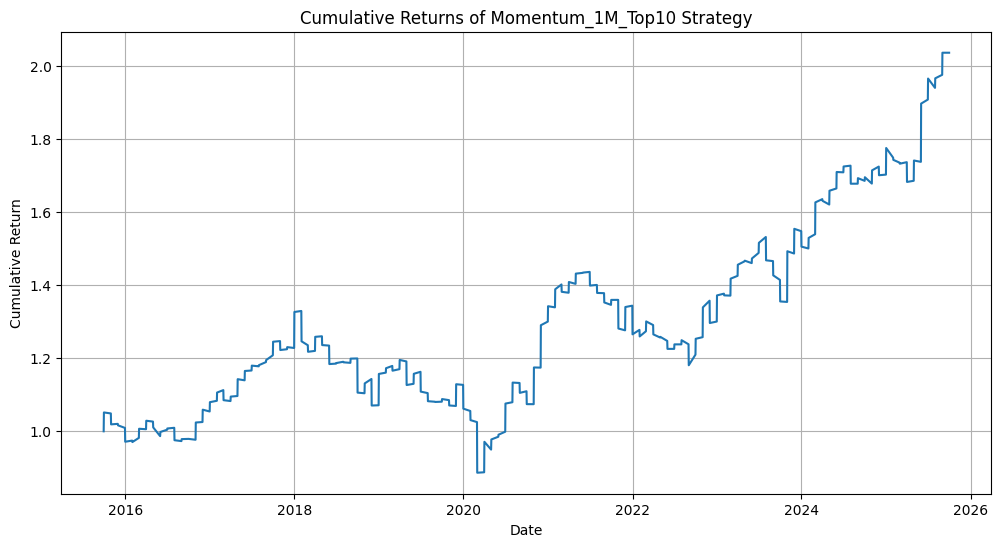

In [253]:
import matplotlib.pyplot as plt

# 1. Select the backtest results DataFrame corresponding to the best_strategy
best_strategy_name = best_strategy.name
best_strategy_results_df = backtest_results[best_strategy_name]

# 2. Calculate the cumulative returns for the best strategy's portfolio
return_cols = [col for col in best_strategy_results_df.columns if col.endswith('_Return')]
monthly_portfolio_returns = best_strategy_results_df[return_cols].mean(axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + monthly_portfolio_returns.fillna(0)).cumprod()
# Adjust to start from 1 at the beginning of the backtest period
cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]

# 3. Create a line plot of the cumulative returns over time.
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values)

# 4. Add a title and axis labels to the plot
plt.title(f"Cumulative Returns of {best_strategy_name} Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)

# 5. Display the plot to visualize the performance of the best strategy.
plt.show()

In [256]:
# N개월 모멘텀 및 상위 N개 설정
N_months = 1
top_n_stocks = 10

# 백테스팅 함수 실행
backtest_results_df = momentum_backtest_monthly_price(monthly_price, rep_etfs, N_months_momentum=N_months, top_n=top_n_stocks)

In [257]:
backtest_results_df.to_excel('backtest.xlsx')